# sprint20 自然言語処理 

In [1]:
import gc
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold

%matplotlib inline

In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [4]:
!cat aclImdb/README

'cat' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [162]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')

In [163]:
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [88]:
print("x : {}".format(y_train[0]))

x : 1


In [10]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。  
この時使用したテキスト全体のことを コーパス と呼びます。  
語彙はコーパスに含まれる言葉よって決まり、それを特徴量としてモデルの学習を行います。  
そのため、テストデータではじめて登場する語彙はベクトル化される際に無視されます。

BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。  
何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。  
デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。  
デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、
「a」や「I」などがカウントされません。  
英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。  
しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。  

In [12]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


# 【問題１】 BoWのスクラッチ実装（unigram & 2_gram）

In [35]:
bow_dataset = \
["This movie is SOOOO funny!!!",
"What a movie! I never",
"best movie ever!!!!! this movie"]

In [78]:
# column list を作成する。
# index に合わせて、カウントしていく。

get_columns = []

for str1 in bow_dataset:
    temp = str1.replace("!","")
    temp = temp.split(" ")
    for wrd in temp:
        if wrd in get_columns:
            pass
        else:
            get_columns.append(wrd)

df = pd.DataFrame(index=range(len(bow_dataset)),columns=get_columns)

for i,str1 in enumerate(bow_dataset):
    temp = str1.replace("!","")
    temp = temp.split(" ")
    df.iloc[i] = 0
    for wrd in temp:
        df.iloc[i][wrd]  += 1


In [79]:
df

,This,movie,is,SOOOO,funny,What,a,I,never,best,ever,this
0,1,1,1,1,1,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0,0
2,0,2,0,0,0,0,0,0,0,1,1,1


In [149]:
# column list を作成する。
# index に合わせて、カウントしていく。

ngram=2
get_columns = []
for str1 in bow_dataset:
    temp = str1.replace("!","")
    temp = temp.split(" ")
    for i in range(len(temp) - ngram + 1):
        
        ngram_word =" ".join(temp[i:i+ngram])
        if ngram_word not in get_columns:
            get_columns.append(ngram_word)

df = pd.DataFrame(index=range(len(bow_dataset)),columns=get_columns)



In [151]:
for i,str1 in enumerate(bow_dataset):
    temp = str1.replace("!","")
    temp = temp.split(" ")
    df.iloc[i] = 0
    for j in range(len(temp)-ngram + 1):
        ngram_word = " ".join(temp[j:j+ngram])
        df.iloc[i][ngram_word]  += 1

In [152]:
df

,This movie,movie is,is SOOOO,SOOOO funny,What a,a movie,movie I,I never,best movie,movie ever,ever this,this movie
0,1,1,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,1,1


## 【問題2】TF-IDFの計算

In [5]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hirot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = x_train
vectorizer = TfidfVectorizer(stop_words=stopWords,token_pattern=r'(?u)\b\w+\b', max_features=50)

# norm = Noneといれることで正則化が行われなくなる。

# fit することでvocabluaryが設定される。
X=vectorizer.fit_transform(corpus)
#vocab = vectorizer.vocabulary_

#print(vectorizer.get_feature_names())

#X = vectorizer.fit_transform(corpus).toarray()
# toarray()で、スパース表現→配列表現にできる。

In [8]:
X[1].toarray()

array([[0.        , 0.12785745, 0.39821412, 0.        , 0.43800216,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.22692136, 0.        , 0.        , 0.        , 0.12816108,
        0.12526271, 0.10609775, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.130662  ,
        0.        , 0.42312832, 0.32387604, 0.13799925, 0.2456185 ,
        0.        , 0.17039113, 0.        , 0.14138692, 0.23765553,
        0.        , 0.        , 0.        , 0.11557921, 0.        ,
        0.16340563, 0.        , 0.        , 0.        , 0.11146519,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

＜メモ＞  
stop_wordsを使用することで、英語で使い古される単語をfeatures に含めないようにする。  
r(?u)\b\n+\b　ｒは正規化、「raw_string」。  
?u は、unicodeを探索せよという意味、\bは空文字を探索せよ、\wはストリング、  
＋は、直前のパターン（この場合はストリング）を１回以上繰り返すという意味である。すなわち、  
" abcd "のような表現を探索せよという意味である。  

## 【問題3】TF-IDFを用いた学習

In [9]:
vectorizer1 = TfidfVectorizer(stop_words=stopWords,token_pattern=r'(?u)\b\w+\b', max_features=5000)
X=vectorizer1.fit_transform(corpus)
vocab = vectorizer1.vocabulary_

vectorizer2 = TfidfVectorizer(stop_words=stopWords,token_pattern=r'(?u)\b\w+\b', max_features=5000,vocabulary=vocab)
X_test = vectorizer2.fit_transform(x_test)

##　vocab　により、フィット時に選択された5000の単語による特徴量をテスト用データに流用させることで予測精度を向上させている。

In [10]:
X_test.shape

(25000, 5000)

In [11]:
from sklearn import linear_model
Y = y_train
clf = linear_model.SGDClassifier()
clf.fit(X, Y)
y_pred = clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.88176

In [14]:
#　2_gramの場合　#
vectorizer1_ng2 = TfidfVectorizer(stop_words=stopWords, ngram_range=(2,2),token_pattern=r'(?u)\b\w+\b', max_features=5000)
X=vectorizer1_ng2.fit_transform(corpus)
vocab2 = vectorizer1_ng2.vocabulary_

vectorizer2_ng2 = TfidfVectorizer(stop_words=stopWords, ngram_range=(2,2),token_pattern=r'(?u)\b\w+\b', max_features=5000,
                                 vocabulary=vocab2)
X_test = vectorizer2_ng2.fit_transform(x_test)

In [15]:
from sklearn import linear_model
Y = y_train
clf = linear_model.SGDClassifier()
clf.fit(X, Y)
y_pred = clf.predict(X_test)

In [16]:
#2-gramにすると、精度が落ちた
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.81496

## 【問題4】TF-IDFのスクラッチ実装

In [155]:
XX = df

sample = df.shape[0]
for i in range(df.shape[0]):
    all_token = np.sum(df.loc[i,:])
    for str in df.columns:
        XX.loc[i,str] = df.loc[i,str]/all_token * np.log(sample/(df[str]>0).sum())
        
XX

,This movie,movie is,is SOOOO,SOOOO funny,What a,a movie,movie I,I never,best movie,movie ever,ever this,this movie
0,0.274653,0.274653,0.274653,0.274653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.274653,0.274653,0.274653,0.274653,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.274653,0.274653,0.274653,0.274653


In [156]:
XX1 = df

sample = df.shape[0]
for i in range(df.shape[0]):
    all_token = np.sum(df.loc[i,:])
    for str in df.columns:
        XX1.loc[i,str] = np.log((1+sample)/(1+(df[str]>0).sum())+1) * df.loc[i,str]
  
XX1

,This movie,movie is,is SOOOO,SOOOO funny,What a,a movie,movie I,I never,best movie,movie ever,ever this,this movie
0,0.301737,0.301737,0.301737,0.301737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.301737,0.301737,0.301737,0.301737,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301737,0.301737,0.301737,0.301737


# Word2Vec

In [7]:
pip install gensim

  Created wheel for smart-open: filename=smart_open-1.10.0-cp37-none-any.whl size=90638 sha256=2db4623b66edacad7ac1f8e11fbe8768bb74f08bd5bf3046586f2e3cb71c388f
  Stored in directory: C:\Users\hirot\AppData\Local\pip\Cache\wheels\f8\00\d4\a6b8b6aa241459103d19e757f96645549dd562d5b5de653f44
  Created wheel for googleapis-common-protos: filename=googleapis_common_protos-1.51.0-cp37-none-any.whl size=77603 sha256=93440ee1a782f2a126f930e703f8a55245491c975f0d85c5e2fba1fd5365a534
  Stored in directory: C:\Users\hirot\AppData\Local\pip\Cache\wheels\2c\f9\7f\6eb87e636072bf467e25348bbeb96849333e6a080dca78f706
Successfully built smart-open googleapis-common-protos
Note: you may need to restart the kernel to use updated packages.


In [8]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.02098105  0.02258059  0.02851041 -0.00124121  0.03891818  0.04506667
 -0.0109305   0.01840642  0.02327806 -0.00697161]
movieのベクトル : 
[-0.00066643  0.02399119 -0.02114978  0.028674    0.03904394  0.03756126
  0.04605712  0.04721591 -0.03711565  0.04108435]
isのベクトル : 
[ 0.03116227 -0.04661803  0.01974387  0.01425194  0.04564355  0.01820397
 -0.02511046  0.02846979  0.04203334 -0.03212313]
veryのベクトル : 
[-0.04773384 -0.00348218 -0.01315404  0.00433041 -0.00785528  0.01832622
 -0.03504654 -0.03432597  0.03548326 -0.04261057]
goodのベクトル : 
[-0.03624356  0.01948744 -0.00224068 -0.01728424 -0.00658405  0.03463987
  0.03276391 -0.01304061 -0.0311131  -0.04174571]
filmのベクトル : 
[ 0.0390854   0.03092853 -0.03155345  0.03109247 -0.00609201 -0.02193109
  0.01128496 -0.01367472  0.01945359 -0.03267679]
aのベクトル : 
[ 0.0478286  -0.00469719  0.0167172   0.00841532 -0.03170535  0.02022313
  0.01855317  0.0237371

C:\Users\hirot\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [10]:
model.wv.most_similar(positive="good", topn=3)

[('very', 0.29364627599716187),
 ('this', 0.2116437554359436),
 ('movie', 0.1516377478837967)]

C:\Users\hirot\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


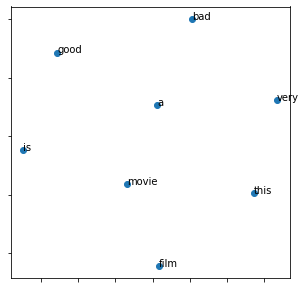

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## 【問題5】コーパスの前処理

In [298]:
### ストップワードの定義

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.append("www")
stop_words.append("br")
stop_words.append("http")

In [299]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [233]:
#　前処理：全体を小文字にするlower、正規表現で文章構成要素を分解、リスト内包の繰り返し処理で""を排除、ストップワードの排除。
#　lowerで処理が停止する場合は、上記のｘ_trainなどを再定義する。

pp_x_train = x_train
for sample_num in range(len(x_train)):
    temp = x_train[sample_num].lower()
    temp = re.findall(r"(?u)\b\w\w+\b",temp)
    temp = [temp[i*2] for i in range(int(len(temp)/2))]
    temp = [word for word in temp if word not in stop_words]
    pp_x_train[sample_num] = temp

## 【問題6】Word2Vecの学習

In [311]:
# word2vecによる学習。diverとほぼ同文。計算処理負荷、2値分類を行うため特徴量を30とした。

from gensim.models import Word2Vec
model = Word2Vec(min_count=1, size=30) # 次元数を30に設定
model.build_vocab(pp_x_train) # 準備
model.train(pp_x_train, total_examples=model.corpus_count, epochs=model.iter) # 学習
#print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
#for vocab in model.wv.vocab.keys():
#   print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

C:\Users\hirot\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(7191605, 7472095)

In [312]:
#　適当な単語の分散表現
model.wv["like"]

array([ 0.47412086,  0.5733074 , -0.38808358,  0.4709022 ,  0.42264494,
       -1.3199958 ,  0.6007901 ,  1.1138368 ,  0.03360257, -0.17457487,
       -0.6862977 , -1.9612445 , -2.5635514 , -0.2549451 ,  1.0476553 ,
       -1.4398404 , -1.2268697 ,  0.47406617,  1.081101  , -0.65287375,
       -0.16128549,  0.39934334, -0.17143781,  0.05266453,  0.85679615,
       -0.93853444, -2.3548982 , -0.06048483,  1.8899999 , -1.0690849 ],
      dtype=float32)

## 【問題8】Word2Vecの学習結果（分散表現）を用いた文書分類

In [239]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [281]:
## 入力：前処理されたトレイン、テストデータ。出力：30特徴量による分散表現。

def make_all(pp_sentense):

    data_feature = np.zeros((len(pp_sentense),30))

    for i in range(len(pp_sentense)):
        data_feature[i] = make_data1(pp_sentense[i])
    return data_feature
    

In [255]:
### shapeの問題で処理がなぜか止まるので、make_all関数内でmake_data1関数を繰り返し実行する構造にしている。
### 入力：前処理されたトレイン、テストデータの１サンプル。出力：30特徴量で分散表現された1サンプル。
###　今回の特徴量は、1サンプル内の全単語の分散表現の合計値を正規化したものとした。

def make_data1(pp_sentense):
    sentense_features = np.zeros(30)
    for word in pp_sentense:
        sentense_features += model.wv[word]

    data_feature = scaler.fit_transform(sentense_features.reshape(-1,1))
    return data_feature.reshape(1,-1)

In [285]:
make_all(pp_x_train[0:2])

array([[ 0.78899095,  0.99042181, -1.17629177,  1.23811069,  0.14526573,
        -1.47146235,  0.49844051,  2.28492101, -0.35230013, -0.06783827,
        -0.81375075, -1.45007181, -1.18424343, -0.62499454,  1.7571657 ,
        -1.02968619, -0.80964854, -0.59406694,  0.75027452, -1.33023401,
         0.06132184,  0.61822049,  0.78033367,  0.54698898,  0.27888579,
        -0.49643085, -1.46692682,  0.36418719,  1.19006275,  0.57435479],
       [ 0.57161173,  0.99331906, -0.941552  ,  1.38521073,  0.48289026,
        -1.58383487,  0.42121845,  2.10278855, -0.53610177, -0.34558234,
        -0.90759965, -1.56623046, -0.97367932,  0.20619229,  1.93196708,
        -0.99420177, -1.05356566, -0.29996199,  1.2809279 , -0.76097884,
         0.01359021,  0.55740344,  1.11624002,  0.34824756,  0.02087206,
        -0.7712616 , -1.42721606,  0.31398244,  0.99193411, -0.57662953]])

In [300]:
##　テストデータの単語がトレインデータの単語に含まれないケースがある。トレインデータの単語に含まれない単語を排除した（加筆箇所）。

pp_x_test = x_test
for sample_num in range(len(x_test)):
    temp = x_test[sample_num].lower()
    temp = re.findall(r"(?u)\b\w\w+\b",temp)
    temp = [temp[i*2] for i in range(int(len(temp)/2))]
    temp = [word for word in temp if word not in stop_words]
    temp = [word for word in temp if word in model.wv.vocab.keys()]    ##　加筆　##
    pp_x_test[sample_num] = temp

In [ ]:
##前処理されたトレインデータ、テストデータをmake_allで分散表現に変換しＳＶＣで２値分類を行った。

In [303]:
X_traindata = make_all(pp_x_train)

In [302]:
X_testdata = make_all(pp_x_test)

In [304]:
from sklearn.svm import SVC
clf2 = SVC(gamma='auto')
svm_w2v = clf2.fit(X_traindata, y_train)

In [305]:
y_pred = svm_w2v.predict(X_testdata)

In [307]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.76328